Start with our usual setup, including the utility methods from last time.

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Make matplotlib figures appear inline in the
# notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def lin_map(val, r_src, r_dst):
    percent = (val - r_src[0]) / (r_src[1] - r_src[0])
    return percent * (r_dst[1] - r_dst[0]) + r_dst[0]

def clamp_range(img):
    min_ = min(img.flatten())
    max_ = max(img.flatten())

    # Apparently this code is generic enough to handle multidimensional arrays?
    return lin_map(img, [min_, max_], [0., 1.])

def difference(a, b):
    return np.abs((a / 255. - b / 255.))

def display(img, title=None):
    # Show image
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

First, we're going to explore the Gaussian kernel. You may need to run `pip3 install opencv-python` and restart Jupyter notebook.

In [85]:
import cv2
filter = cv2.getGaussianKernel(5, 1)

As we might expect, this returns a 1x5 Gaussian kernel, where the standard deviation is 1. We can use two of these kernels to create a 2d filter, or we can use the higher level function GaussianBlur. Let's try that next. We'll compare the output of the Gaussian blur filter to the simple moving average blur filter we learned about earlier.

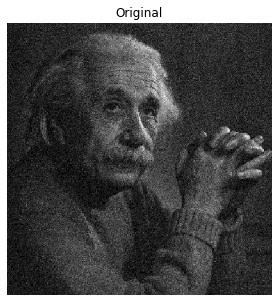

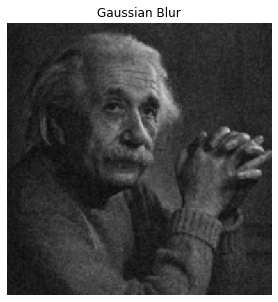

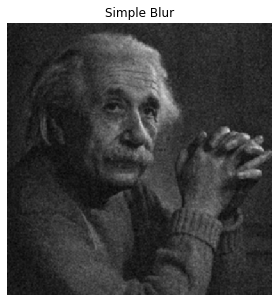

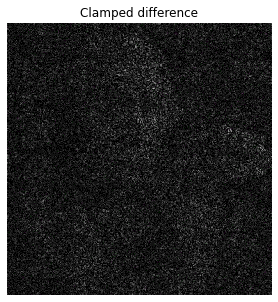

In [86]:
image = cv2.imread('./noisy_einstein.png')
display(image, "Original")

blur_image = cv2.GaussianBlur(image, (11,11), 1)
display(blur_image, "Gaussian Blur")

simple_blur_filter = np.array(
[
    [.11,.11,.11],
    [.11,.11,.11],
    [.11,.11,.11],
])
simple_blur_image = cv2.filter2D(image, -1, simple_blur_filter)
display(simple_blur_image, "Simple Blur")
display(clamp_range(difference(blur_image, simple_blur_image)), "Clamped difference")

# Exercise 1

Recall from lecture that the two parameters to Gaussian blur are kernel size and sigma. How do changing these parameters affect the output of the blur filter? You may want to find a different example image to illustrate your point.

In [87]:
from skimage import feature, data

image = data.coins()

def canny_annotated(sigma, low_threshold, high_threshold, target=image):
    display(feature.canny(target, sigma, low_threshold, high_threshold), f"Canny sigma={sigma}, low_threshold={low_threshold}, high_threshold={high_threshold}")

First, let's look at the effect of `sigma`. Intuitively, as this goes up, we'll start losing small edges which may either be artifacts such as noise (which would be desirable to remove) or image details such as the edges on the coin faces (which would be potentially undesirable to remove).

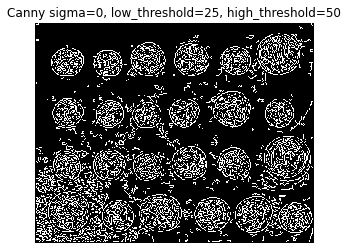

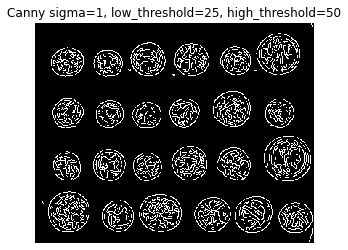

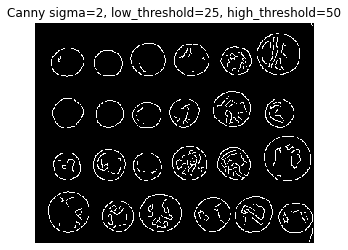

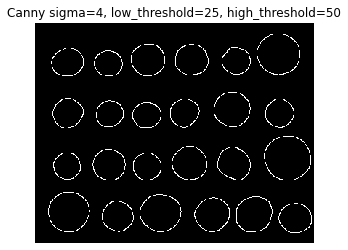

In [88]:
canny_annotated(sigma=0, low_threshold=25, high_threshold=50)
canny_annotated(sigma=1, low_threshold=25, high_threshold=50)
canny_annotated(sigma=2, low_threshold=25, high_threshold=50)
canny_annotated(sigma=4, low_threshold=25, high_threshold=50)

# Exercise 2

**Problem 1:** Play with the thresholds to get different output. How does changing each threshold affect the edges that the algorithm finds?

To better understand the thresholds at play, let's view the images before double thresholding is applied to see which gray edges might become full edges and which edges will be completely ignored.

The low threshold is important for ensuring that the really weak edges found in the background don't end up getting flood-filled when expanding the seed pixels found by the high threshold.

The high threshold is important for determining where to start looking for edges (i.e. it determines the brightness of a guaranteed seed pixel). If it's too low, we'll get a bunch of false positives and a bunch of inner noise will be detected as actual edges. On the other hand, if the high threshold is too high, we might miss entire edges (or even entire objects!)

If we disable double thresholding entirely and set the low and high thresholds equal to each other, a given threshold  may be good enough to detect some edges but may loose edges as they become too dark from the image's artifacts.


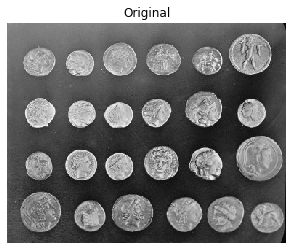

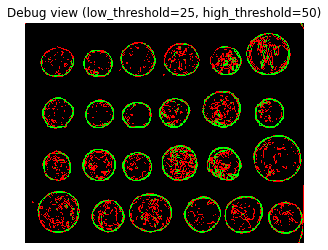

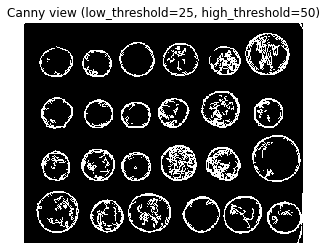

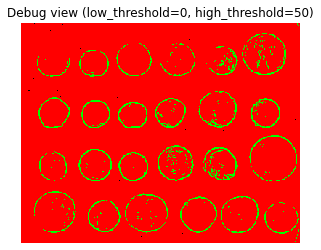

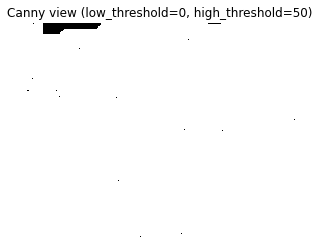

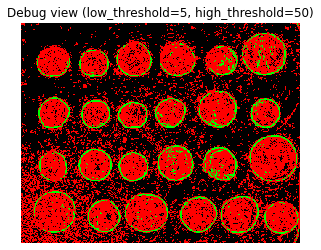

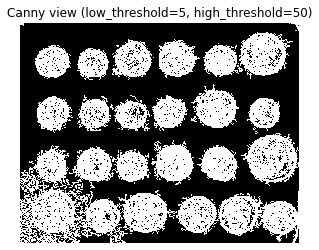

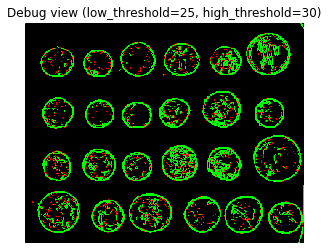

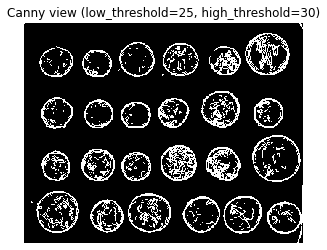

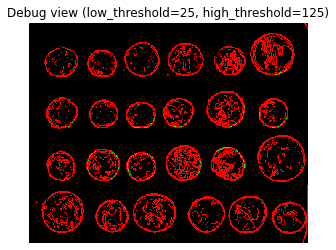

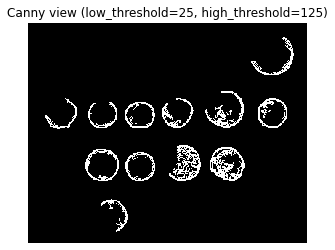

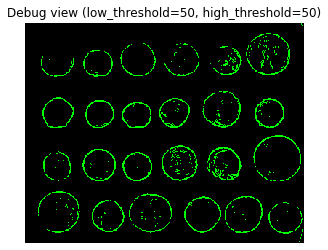

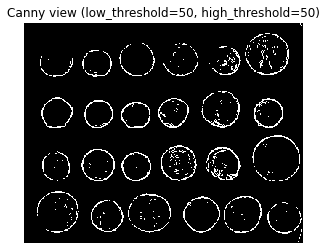

In [89]:
from skimage import filters

# Display the original image as a reminder
display(image, "Original")

# Adapted from the previous notebook.
def double_threshold(original, low_threshold, high_threshold, keep_alive_sz, keep_alive_pop, gen):
    # Generate a boolean mask of pixels above the low threshold
    above_low = original > low_threshold

    # Generate a boolean mask of all alive pixels
    target = original > high_threshold

    # Repeat over the specified number of generations
    for i in range(gen):
        # Use a square blur to get a population percentage of nearby alive pixels.
        populations = cv2.blur(np.where(target, 1., 0.), (keep_alive_sz, keep_alive_sz))

        # Filter the population counts by the required population.
        # Automatically promote pixels that were already white.
        target = target | (populations > keep_alive_pop)

        # Finally, ensure that only gray and white pixels are ever promoted to white.
        target = target & above_low

    return target

def canny_debug(low_threshold, high_threshold):
    # The actual sobel filter and thresholding algorithms used internally are _much_ more complicated
    # but this should provide a somewhat O.K. approximation. Just don't be surprised when "condemned" pixels
    # suddenly show up in the final image when using a more professional implementation!
    sobel = filters.sobel(image)

    non_culled_mask = sobel > low_threshold / 255
    white_mask = sobel > high_threshold / 255

    # Partially stolen from https://scikit-image.org/docs/dev/user_guide/numpy_images.html
    # Look, I'd really like to read the documentation to actually _learn_ how to do stuff like this but
    # this code sample has just convinced me that numpy is a magical library that likes to make up arbitrary
    # rules to make code "just work" just so long as you're willing to turn your back on the crazy magic that
    # even enables this in the first place and now I'm honestly kind-of scared.
    target = np.zeros([image.shape[0], image.shape[1], 3])  # How does it even know which dtype to use?!
    target[non_culled_mask] = [1., 0., 0.]  # Why does this even work?!
    target[white_mask] = [0., 1., 0.]

    settings_suffix = f"low_threshold={low_threshold}, high_threshold={high_threshold}"
    display(target, f"Debug view ({settings_suffix})")

    display(double_threshold(sobel, low_threshold / 255, high_threshold / 255, keep_alive_sz=3, keep_alive_pop=0.1, gen=30), f"Canny view ({settings_suffix})")

# Default reasonable parameters
canny_debug(low_threshold=25, high_threshold=50)

# No low thresholding
canny_debug(low_threshold=0, high_threshold=50)

# Very small low thresholding
canny_debug(low_threshold=5, high_threshold=50)

# Low upper threshold
canny_debug(low_threshold=25, high_threshold=30)

# High upper threshold
canny_debug(low_threshold=25, high_threshold=125)

# Binary threshold
canny_debug(low_threshold=50, high_threshold=50)

**Problem 2:** Imagine that you have an image with lots of false positives: that is, it finds lots of edges that aren't actually edges. How would you adjust thresholds to improve the result?

There are two types of adjustments that can be made: increasing the low threshold and increasing the high threshold. In increasing the low threshold, you can easily eliminate parts of the image that you know will never be edges but this may not be flexible enough as parts of an edge may appear darker than the parts around them and may be culled by the low threshold. Increasing the high threshold is slightly more flexible. By increasing the high threshold, you can more precisely define what should constitute an edge while also giving opportunities to the darker parts of those edges to be recognized as edges.

**Problem 3:** Imagine that you have an image where the edges don't connect well: that is, it finds some edges, but the edges tend to be broken lines instead of solid lines. How would you adjust thresholds to improve the result?

You would want to ensure that the low threshold is not condemning those missing edge pixels and lower it accordingly.

**Problem 4:** Remember from exercise 1 that the two parameters to the Gaussian blur are kernel size and sigma, and that both affect the output of the blur filter. Notice that skimage's canny implementation only takes sigma as a parameter. Without modifying the source code, how might you incorporate a different kernel size into the implementation?

Isn't the kernel size an irrelevant factor so long as the algorithm deciding the kernel size ensures that the kernel edge weights are negligible enough to stop at?

**Problem 5:** Try to improve the edges you find by tweaking the parameters.

...on which image? The one from the previous exercise?

**Problem 6:** Try running the edge detector on some different images. `skimage.data` has a good set to start with. You can also look at [Berkeley's collection of benchmark images](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/). Take notes on which images Canny performs well on, and which it does not.

Most of the images can be improved by blurring the image to drop both the noise and some of the finer details (e.g. hairs on the cat, blades of grass). However, blurring the image doesn't always improve it. In blurring the moon image for example, most of the longer gradients got completely dropped, making the reported edges less descriptive.

Gradients have a tendency of breaking the canny edge detector (and the underlying sobel filter as well). Because they spread the change over a large surface, it is not possible to definitively pinpoint where the "edge" is. Gradients require far more context to interpret than most other images would because looking at local areas will yield a result which is almost indistinguishable from a region with solid colors. The color wheel is especially guilty of this as all of the human-visible creases in the grayscale gradient are completely ignored in both invocations.

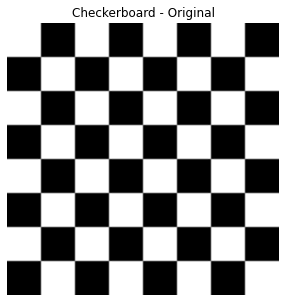

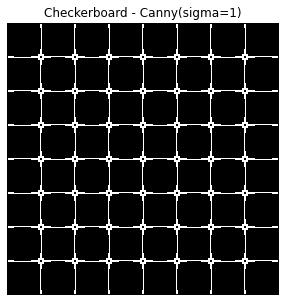

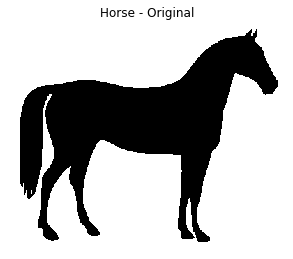

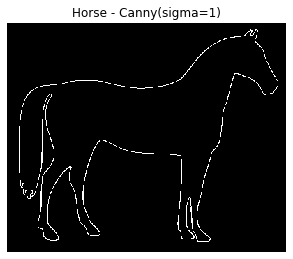

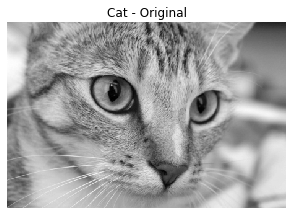

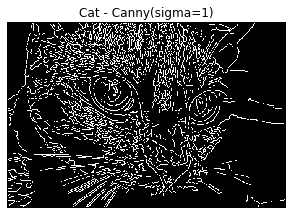

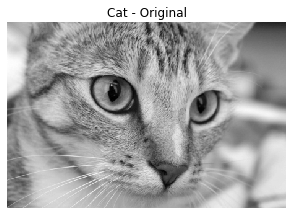

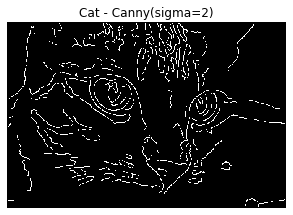

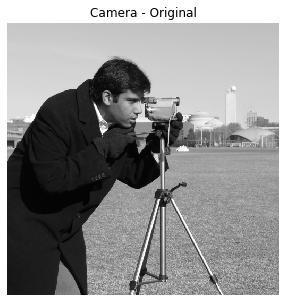

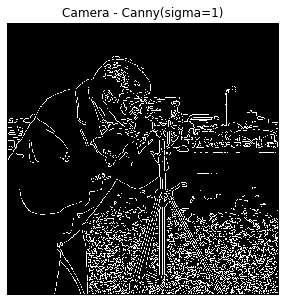

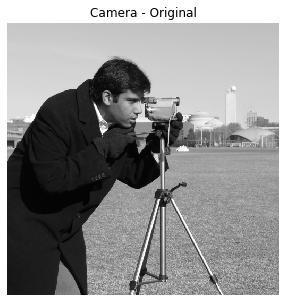

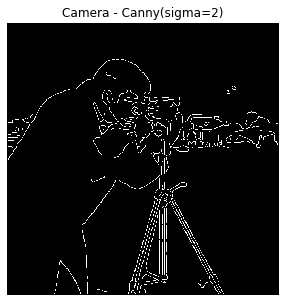

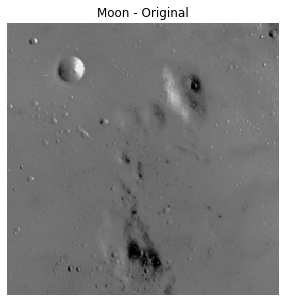

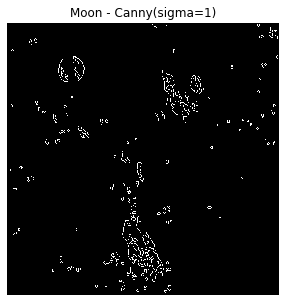

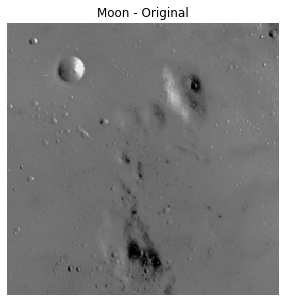

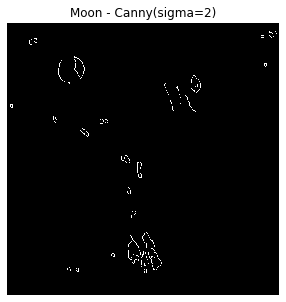

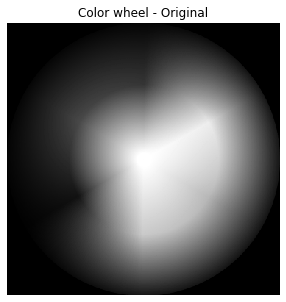

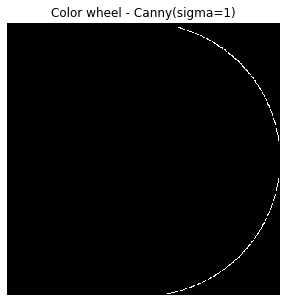

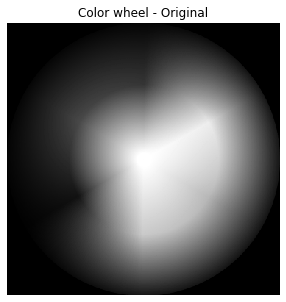

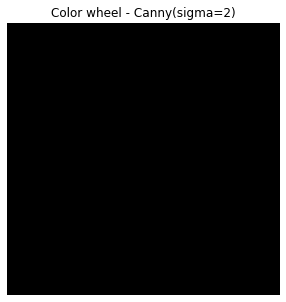

In [90]:
from skimage import data
from skimage.color import rgb2gray

def canny_before_after(target, name, sigma=1):
    display(target, f"{name} - Original")
    display(feature.canny(target, sigma=sigma), f"{name} - Canny(sigma={sigma})")

canny_before_after(data.checkerboard(), "Checkerboard")
canny_before_after(data.horse(), "Horse")
canny_before_after(rgb2gray(data.chelsea()), "Cat")
canny_before_after(rgb2gray(data.chelsea()), "Cat", sigma=2)
canny_before_after(data.camera(), "Camera")
canny_before_after(data.camera(), "Camera", sigma=2)
canny_before_after(data.moon(), "Moon")
canny_before_after(data.moon(), "Moon", sigma=2)
canny_before_after(rgb2gray(data.colorwheel()), "Color wheel")
canny_before_after(rgb2gray(data.colorwheel()), "Color wheel", sigma=2)

# Hough Transform

In this exercise, we'll explore how edge detection and line-finding can be used to implement part of a self-driving car algorithm.

We'll start with the steps we covered in lecture: find the edges and then find the lines.

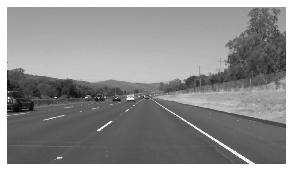

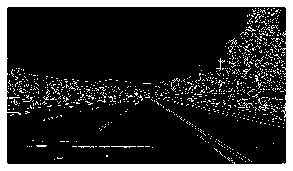

In [91]:
image = cv2.imread('./road.jpg', flags=cv2.IMREAD_GRAYSCALE)

display(image)
edge_image = feature.canny(image, sigma=1, low_threshold=10, high_threshold=30)
display(edge_image)

We'll use the probabilistic hough transform function, as it's a bit easier to work with.

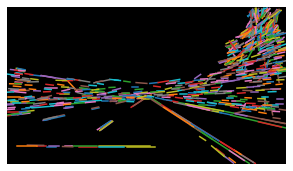

In [92]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(edge_image, threshold=1, line_length=20,
                                 line_gap=5)

plt.figure(figsize = (5,5))
plt.imshow(edge_image * 0)
plt.axis('off')
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))


# Exercise 3

1. We've found some lines. Lots of them, in fact. Using only the techniques we've learned so far, how can we clean up this image to only show the lines that correspond to lanes? Optional: implement some of them and show the improvement in the produced image.

2. We can also use additional information that we have about the image; namely, we know that our images are always coming from a camera mounted on the front of the car. How could we use this information to improve on our lane-finding algorithm? Optional: implement your suggestion and show the improvement in the produced image.

3. A video is just a series of images (usually 30 images per second). Imagine that your lane-finding algorithm is being fed a video from a front-mounted camera. Describe how you would use your lane-finding algorithm to keep the car driving straight and in its lane.

In [93]:
# TODO